All results in this notebook are generated using synthetic data that reproduces statistical characteristics of real-world EV telemetry. No proprietary or client data is included.


In [ ]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, LGBMRegressor

import joblib

from src.generate_data import generate_synthetic_ev_data

df = generate_synthetic_ev_data()
df.to_csv("synthetic_ev_data.csv", index=False)
df.head()



,vehicle_id,timestamp,plugged_in,soc_percent,gap_flag,soc_delta
0,EV_0747a0cd,2026-02-09 16:09:00+00:00,False,74.28,False,NaN
1,EV_0747a0cd,2026-02-09 16:11:00+00:00,False,74.25,False,-0.038
2,EV_0747a0cd,2026-02-09 16:12:00+00:00,False,74.23,False,-0.019
3,EV_0747a0cd,2026-02-09 16:22:00+00:00,False,74.04,False,-0.190
4,EV_0747a0cd,2026-02-09 16:24:00+00:00,False,74.00,False,-0.038


In [ ]:
# Standardize column names to match pipeline expectations

df = df.rename(columns={
    "vehicle_id": "asset_id",
    "plugged_in": "is_plugged_in",
    "soc_percent": "soc",
    "interval_start_utc": "timestamp",
})

# Ensure correct dtypes
df["timestamp"] = pd.to_datetime(df["timestamp"], format="ISO8601", utc=True)
df["is_plugged_in"] = df["is_plugged_in"].astype(int)

df.head()


,asset_id,timestamp,is_plugged_in,soc,gap_flag,soc_delta
0,EV_0747a0cd,2026-02-09 16:09:00+00:00,0,74.28,False,NaN
1,EV_0747a0cd,2026-02-09 16:11:00+00:00,0,74.25,False,-0.038
2,EV_0747a0cd,2026-02-09 16:12:00+00:00,0,74.23,False,-0.019
3,EV_0747a0cd,2026-02-09 16:22:00+00:00,0,74.04,False,-0.190
4,EV_0747a0cd,2026-02-09 16:24:00+00:00,0,74.00,False,-0.038


Step 1: Preprocessing (Gap Detection Properly)

In [4]:
from src.preprocessing import (
    parse_and_sort,
    compute_time_diff,
    flag_gaps,
    filter_short_assets,
)

df = parse_and_sort(df)
df = compute_time_diff(df)
df = flag_gaps(df, gap_threshold=240)
df = filter_short_assets(df)

df.head()


,asset_id,timestamp,is_plugged_in,soc,gap_flag,soc_delta,time_diff_minutes
0,EV_0747a0cd,2026-02-09 16:09:00+00:00,0,74.28,False,NaN,NaN
1,EV_0747a0cd,2026-02-09 16:11:00+00:00,0,74.25,False,-0.038,2.0
2,EV_0747a0cd,2026-02-09 16:12:00+00:00,0,74.23,False,-0.019,1.0
3,EV_0747a0cd,2026-02-09 16:22:00+00:00,0,74.04,False,-0.190,10.0
4,EV_0747a0cd,2026-02-09 16:24:00+00:00,0,74.00,False,-0.038,2.0


Step 2: Feature Engineering

In [5]:
from src.feature_engineering import (
    compute_soc_delta,
    add_time_features,
    add_lag_features,
    create_targets,
)

df = compute_soc_delta(df)
df = add_time_features(df)
df = add_lag_features(df, lags=[1, 2, 3])
df = create_targets(df, horizon_steps=1)

df = df.dropna()

df.head()


,asset_id,timestamp,is_plugged_in,soc,gap_flag,soc_delta,time_diff_minutes,hour,day_of_week,soc_lag_1,soc_lag_2,soc_lag_3,plug_future,soc_future,energy_to_full_future
3,EV_0747a0cd,2026-02-09 16:22:00+00:00,0,74.04,False,-0.19,10.0,16,0,74.23,74.25,74.28,0.0,74.00,26.00
4,EV_0747a0cd,2026-02-09 16:24:00+00:00,0,74.00,False,-0.04,2.0,16,0,74.04,74.23,74.25,0.0,73.87,26.13
5,EV_0747a0cd,2026-02-09 16:31:00+00:00,0,73.87,False,-0.13,7.0,16,0,74.00,74.04,74.23,0.0,73.77,26.23
6,EV_0747a0cd,2026-02-09 16:36:00+00:00,0,73.77,False,-0.10,5.0,16,0,73.87,74.00,74.04,0.0,73.62,26.38
7,EV_0747a0cd,2026-02-09 16:44:00+00:00,0,73.62,False,-0.15,8.0,16,0,73.77,73.87,74.00,0.0,73.52,26.48


Step 3: Train Models

In [6]:
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import train_test_split

feature_cols = [
    "soc",
    "soc_delta",
    "hour",
    "day_of_week",
    "soc_lag_1",
    "soc_lag_2",
    "soc_lag_3",
]

X = df[feature_cols]

# Classification target
y_class = df["plug_future"]

# Regression target
y_reg = df["energy_to_full_future"]

# Split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

# Train classifier
clf = LGBMClassifier(n_estimators=200, learning_rate=0.05)
clf.fit(X_train_c, y_train_c)

# Train regressor
reg = LGBMRegressor(n_estimators=200, learning_rate=0.05)
reg.fit(X_train_r, y_train_r)


[LightGBM] [Info] Number of positive: 401, number of negative: 627
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1198
[LightGBM] [Info] Number of data points in the train set: 1028, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390078 -> initscore=-0.446985
[LightGBM] [Info] Start training from score -0.446985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Step 4: Evaluation

Classification

In [7]:
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

prob_preds = clf.predict_proba(X_test_c)[:, 1]
class_preds = clf.predict(X_test_c)

auc = roc_auc_score(y_test_c, prob_preds)

print("ROC AUC:", auc)
print(confusion_matrix(y_test_c, class_preds))
print(classification_report(y_test_c, class_preds))


ROC AUC: 0.956864448857994
[[137  15]
 [  6 100]]
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93       152
         1.0       0.87      0.94      0.90       106

    accuracy                           0.92       258
   macro avg       0.91      0.92      0.92       258
weighted avg       0.92      0.92      0.92       258



Regression

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

reg_preds = reg.predict(X_test_r)

mae = mean_absolute_error(y_test_r, reg_preds)
rmse = np.sqrt(mean_squared_error(y_test_r, reg_preds))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 0.27816070329912784
RMSE: 0.4774270297201686


Step 5: Visual Diagnostics

Confusion Matrix

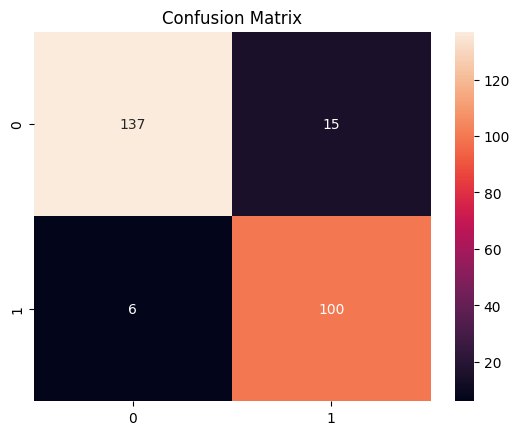

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_c, class_preds)

sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()


Residual Plot

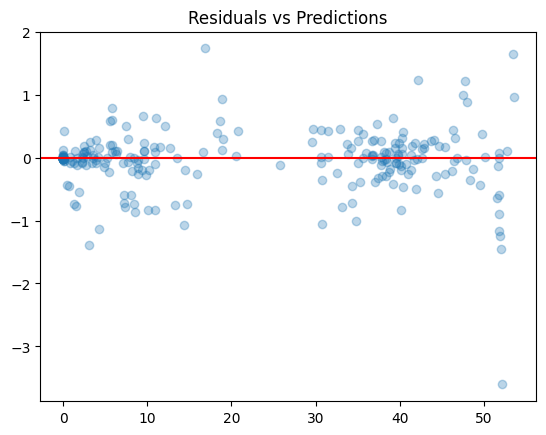

In [10]:
residuals = y_test_r - reg_preds

plt.scatter(reg_preds, residuals, alpha=0.3)
plt.axhline(0, color="red")
plt.title("Residuals vs Predictions")
plt.show()
